# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">1. Model Training for Heart Failure Prediction Dataset</p>

### Loading the necessary Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier



# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Read the Dataset</p>

In [3]:
df = pd.read_csv('./data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-al'ign:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Getting X and Y variables</p>

In [4]:
X = df.drop(labels=['HeartDisease'],axis=1)
Y = df[['HeartDisease']]

# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Creating Data Transformation Pipeline</p>

### Creating Pipeline with Column Transformer

In [5]:

categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

for col in categorical_cols:
    unique_values = X[col].unique()
    print(f'{col} has {len(unique_values)} unique values which are {unique_values}')

Sex has 2 unique values which are ['M' 'F']
ChestPainType has 4 unique values which are ['ATA' 'NAP' 'ASY' 'TA']
RestingECG has 3 unique values which are ['Normal' 'ST' 'LVH']
ExerciseAngina has 2 unique values which are ['N' 'Y']
ST_Slope has 3 unique values which are ['Up' 'Flat' 'Down']


In [6]:


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OneHotEncoder()),
                ('scaler',StandardScaler(with_mean=False))
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Train Test Split</p>

In [7]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Transforming the data with pipeline created</p>

In [8]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [9]:
preprocessor.get_feature_names_out()

array(['num_pipeline__Age', 'num_pipeline__RestingBP',
       'num_pipeline__Cholesterol', 'num_pipeline__FastingBS',
       'num_pipeline__MaxHR', 'num_pipeline__Oldpeak',
       'cat_pipeline__Sex_F', 'cat_pipeline__Sex_M',
       'cat_pipeline__ChestPainType_ASY',
       'cat_pipeline__ChestPainType_ATA',
       'cat_pipeline__ChestPainType_NAP',
       'cat_pipeline__ChestPainType_TA', 'cat_pipeline__RestingECG_LVH',
       'cat_pipeline__RestingECG_Normal', 'cat_pipeline__RestingECG_ST',
       'cat_pipeline__ExerciseAngina_N', 'cat_pipeline__ExerciseAngina_Y',
       'cat_pipeline__ST_Slope_Down', 'cat_pipeline__ST_Slope_Flat',
       'cat_pipeline__ST_Slope_Up'], dtype=object)

In [10]:
xtrain.head()

,num_pipeline__Age,num_pipeline__RestingBP,num_pipeline__Cholesterol,num_pipeline__FastingBS,num_pipeline__MaxHR,num_pipeline__Oldpeak,cat_pipeline__Sex_F,cat_pipeline__Sex_M,cat_pipeline__ChestPainType_ASY,cat_pipeline__ChestPainType_ATA,cat_pipeline__ChestPainType_NAP,cat_pipeline__ChestPainType_TA,cat_pipeline__RestingECG_LVH,cat_pipeline__RestingECG_Normal,cat_pipeline__RestingECG_ST,cat_pipeline__ExerciseAngina_N,cat_pipeline__ExerciseAngina_Y,cat_pipeline__ST_Slope_Down,cat_pipeline__ST_Slope_Flat,cat_pipeline__ST_Slope_Up
0,-1.245067,-0.708985,0.372803,1.842609,2.284353,-0.097061,0.000000,2.390385,0.000000,0.0,2.411241,0.0,0.0,2.045529,0.0,2.031122,0.000000,4.044952,0.00000,0.000000
1,-1.886236,-0.166285,0.086146,-0.542709,1.652241,-0.836286,0.000000,2.390385,0.000000,0.0,2.411241,0.0,0.0,2.045529,0.0,2.031122,0.000000,0.000000,0.00000,2.027276
2,0.250993,0.919115,0.123134,1.842609,-0.441628,0.087745,0.000000,2.390385,2.008638,0.0,0.000000,0.0,0.0,2.045529,0.0,0.000000,2.031122,0.000000,2.00107,0.000000
3,-1.779375,-0.166285,0.104640,-0.542709,0.229991,-0.836286,2.390385,0.000000,0.000000,0.0,2.411241,0.0,0.0,2.045529,0.0,2.031122,0.000000,0.000000,0.00000,2.027276
4,-0.283314,-0.708985,-1.846478,1.842609,-1.271274,-0.836286,0.000000,2.390385,2.008638,0.0,0.000000,0.0,0.0,2.045529,0.0,2.031122,0.000000,0.000000,2.00107,0.000000


In [11]:
xtest.head()

,num_pipeline__Age,num_pipeline__RestingBP,num_pipeline__Cholesterol,num_pipeline__FastingBS,num_pipeline__MaxHR,num_pipeline__Oldpeak,cat_pipeline__Sex_F,cat_pipeline__Sex_M,cat_pipeline__ChestPainType_ASY,cat_pipeline__ChestPainType_ATA,cat_pipeline__ChestPainType_NAP,cat_pipeline__ChestPainType_TA,cat_pipeline__RestingECG_LVH,cat_pipeline__RestingECG_Normal,cat_pipeline__RestingECG_ST,cat_pipeline__ExerciseAngina_N,cat_pipeline__ExerciseAngina_Y,cat_pipeline__ST_Slope_Down,cat_pipeline__ST_Slope_Flat,cat_pipeline__ST_Slope_Up
0,0.999024,0.376415,-0.043312,-0.542709,1.691748,-0.836286,2.390385,0.000000,0.000000,2.552291,0.000000,0.0,0.000000,2.045529,0.000000,2.031122,0.000000,0.0,0.00000,2.027276
1,-0.069591,0.647765,2.943471,-0.542709,-0.244093,-0.836286,0.000000,2.390385,0.000000,0.000000,2.411241,0.0,0.000000,2.045529,0.000000,2.031122,0.000000,0.0,2.00107,0.000000
2,1.212747,1.461816,-1.846478,1.842609,-0.560148,0.272552,0.000000,2.390385,2.008638,0.000000,0.000000,0.0,0.000000,0.000000,2.538395,2.031122,0.000000,0.0,2.00107,0.000000
3,0.250993,-0.166285,-1.846478,-0.542709,-0.560148,0.087745,0.000000,2.390385,2.008638,0.000000,0.000000,0.0,2.486137,0.000000,0.000000,0.000000,2.031122,0.0,2.00107,0.000000
4,0.037270,-1.360226,1.010846,-0.542709,0.783088,-0.836286,0.000000,2.390385,0.000000,2.552291,0.000000,0.0,0.000000,2.045529,0.000000,2.031122,0.000000,0.0,0.00000,2.027276


# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Model Training Baseline models</p>

### Create an Evaluate Function to give all metrics after model Training

In [12]:
def evaluate_model(true, predicted, predicted_proba=None):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    
    return accuracy, precision, recall, f1

### Training Various models

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}
model_list = []
accuracy_list = []
f1_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_accuracy , model_train_precision, model_train_recall ,model_train_recall_f1 = evaluate_model(ytrain, y_train_pred)

    model_test_accuracy , model_test_precision, model_test_recall ,model_test_recall_f1 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_recall_f1))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_recall_f1))
    
    accuracy_list.append(model_test_accuracy)
    f1_list.append(model_test_recall_f1)
    
    print('='*35)
    print('\n')

Logistic Regression
Model performance for Training set
- Accuracy: 0.8719
- Precision: 0.9000
- Recall: 0.8411
- F1 Score: 0.8696
----------------------------------
Model performance for Test set
- Accuracy: 0.8533
- Precision: 0.9000
- Recall: 0.8411
- F1 Score: 0.8696


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.8856
- Precision: 0.9091
- Recall: 0.8411
- F1 Score: 0.8738
----------------------------------
Model performance for Test set
- Accuracy: 0.8587
- Precision: 0.9091
- Recall: 0.8411
- F1 Score: 0.8738


Support Vector Classifier
Model performance for Training set
- Accuracy: 0.8978
- Precision: 0.9135
- Recall: 0.8879
- F1 Score: 0.9005
----------------------------------
Model performance for Test set
- Accuracy: 0.8859
- Precision: 0.9135
- Recall: 0.8879
- F1 Score: 0.9005


Decision Tree Classifier
Model performance for Training set
- Accuracy: 1.0000
- Precision: 0.8710
- Recall: 0.7570
- F1 Score: 0.8100
----------------------------------
Mo

### Results

In [14]:
df_results = pd.DataFrame(list(zip(model_list, f1_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
6,CatBoost Classifier,0.910798
2,Support Vector Classifier,0.900474
8,Gradient Boosting Classifier,0.895238
5,XGBClassifier,0.890995
4,Random Forest Classifier,0.889952
7,AdaBoost Classifier,0.883495
1,K-Neighbors Classifier,0.873786
0,Logistic Regression,0.869565
3,Decision Tree Classifier,0.810000


# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Hyperparameter tuning</p>

### Tuning Catboost

In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score


cbr = CatBoostClassifier(verbose=False)

# Creating the hyperparameter grid
param_dist = {
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'iterations': [100, 200, 300, 400, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9], 
    'border_count': [32, 64, 128],  
    'scale_pos_weight': [1, 2, 5] 
}

# Instantiate RandomizedSearchCV object
rscv = RandomizedSearchCV(
    cbr,
    param_dist,
    scoring=make_scorer(f1_score),  # F1-score for binary classification
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print("Best Parameters:", rscv.best_params_)
print("Best F1-Score:", rscv.best_score_)


Best Parameters: {'scale_pos_weight': 2, 'learning_rate': 0.04, 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 9, 'border_count': 128}
Best F1-Score: 0.8910466527756901


### Definition to print evaluated model results

In [16]:


def print_evaluated_results(model, xtrain, ytrain, xtest, ytest):
    # Predictions
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)
    
    # If probabilities are available, calculate ROC-AUC
    if hasattr(model, "predict_proba"):
        ytest_proba = model.predict_proba(xtest)[:, 1]
        roc_auc = roc_auc_score(ytest, ytest_proba)
    else:
        roc_auc = "N/A"
    
    # Evaluate metrics for training set
    train_accuracy = accuracy_score(ytrain, ytrain_pred)
    train_f1 = f1_score(ytrain, ytrain_pred)
    
    # Evaluate metrics for test set
    test_accuracy = accuracy_score(ytest, ytest_pred)
    test_precision = precision_score(ytest, ytest_pred)
    test_recall = recall_score(ytest, ytest_pred)
    test_f1 = f1_score(ytest, ytest_pred)
    
    # Print results
    print('Model performance for Training set')
    print(f"- Accuracy: {train_accuracy:.4f}")
    print(f"- F1 Score: {train_f1:.4f}")
    print('----------------------------------')
    
    print('Model performance for Test set')
    print(f"- Accuracy: {test_accuracy:.4f}")
    print(f"- Precision: {test_precision:.4f}")
    print(f"- Recall: {test_recall:.4f}")
    print(f"- F1 Score: {test_f1:.4f}")
    print(f"- ROC-AUC: {roc_auc}")
    print('='*35)


In [17]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Accuracy: 0.9700
- F1 Score: 0.9732
----------------------------------
Model performance for Test set
- Accuracy: 0.8967
- Precision: 0.8929
- Recall: 0.9346
- F1 Score: 0.9132
- ROC-AUC: 0.9462313387547032


### model performance has increased after hyper parameter tuning

### Tuning KNN

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

# Initialize KNN
knn = KNeighborsClassifier()

# Parameter grid for 'n_neighbors'
k_range = list(range(2, 31))
param_grid = {'n_neighbors': k_range}

# Fitting the GridSearchCV model
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)  # Use 'f1' for binary classification
grid.fit(xtrain, ytrain.values.flatten())

# Print the best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best F1-Score:", grid.best_score_)


Best Parameters: {'n_neighbors': 7}
Best F1-Score: 0.880861619761124


In [19]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Accuracy: 0.8747
- F1 Score: 0.8889
----------------------------------
Model performance for Test set
- Accuracy: 0.8641
- Precision: 0.9020
- Recall: 0.8598
- F1 Score: 0.8804
- ROC-AUC: 0.924930209976939


### Tuning XGBoost

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

# Initialize SVM classifier
svm = SVC(probability=True)

# Hyperparameter grid for SVM
params = {
    'C': [0.1, 1, 10, 100, 1000],        # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],         # Kernel coefficient
    'degree': [2, 3, 4],                # Degree for 'poly' kernel
}

# RandomizedSearchCV with F1 scoring
rs_svm = RandomizedSearchCV(
    svm,
    param_distributions=params,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    random_state=42
)

# Fit the model
rs_svm.fit(xtrain, ytrain.values.flatten())

# Print the best parameters and score
print("Best Parameters:", rs_svm.best_params_)
print("Best F1-Score:", rs_svm.best_score_)


Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 0.1}
Best F1-Score: 0.8806114800449766


In [21]:
# Selecting best xgb model
best_svm = rs_svm.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_svm,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Accuracy: 0.8692
- F1 Score: 0.8860
----------------------------------
Model performance for Test set
- Accuracy: 0.8587
- Precision: 0.8785
- Recall: 0.8785
- F1 Score: 0.8785
- ROC-AUC: 0.9240199053283165


# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Voting Regressor</p>

In [22]:
from sklearn.ensemble import VotingClassifier

er = VotingClassifier([('cbr',best_cbr),('knn',best_knn)], weights=[2,1])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Accuracy: 0.9700
- F1 Score: 0.9732
----------------------------------
Model performance for Test set
- Accuracy: 0.8967
- Precision: 0.8929
- Recall: 0.9346
- F1 Score: 0.9132
- ROC-AUC: N/A


### Model did not improve with Ensemble technique !

# <p style="padding:10px;background-color:#64AEFE ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Catboost Model Feature Importances</p>

cat_pipeline__ST_Slope_Up          13.499688
num_pipeline__Oldpeak              13.275539
num_pipeline__Cholesterol          10.644672
num_pipeline__Age                   8.582821
cat_pipeline__ChestPainType_ASY     8.402457
num_pipeline__MaxHR                 8.185783
num_pipeline__RestingBP             7.603748
cat_pipeline__ST_Slope_Flat         6.289722
num_pipeline__FastingBS             3.636726
cat_pipeline__ExerciseAngina_N      3.208471
cat_pipeline__Sex_F                 2.993221
cat_pipeline__Sex_M                 2.898348
cat_pipeline__ExerciseAngina_Y      2.675919
cat_pipeline__RestingECG_LVH        1.926887
cat_pipeline__ChestPainType_ATA     1.676128
cat_pipeline__RestingECG_Normal     1.505778
cat_pipeline__ChestPainType_NAP     1.484229
cat_pipeline__RestingECG_ST         0.604345
cat_pipeline__ST_Slope_Down         0.457686
cat_pipeline__ChestPainType_TA      0.447832
dtype: float64




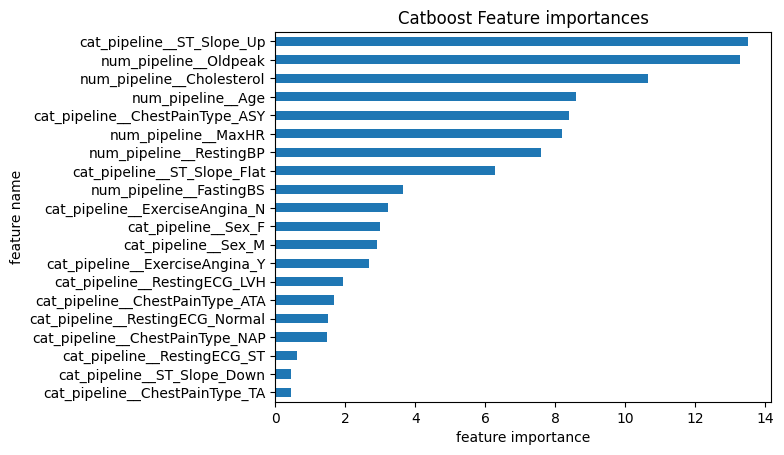

In [23]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()